In [1]:
import pandas as pd
import urllib

import numpy as np

import json

from tqdm.autonotebook import tqdm

#%matplotlib inline

tqdm.pandas()

import dask.dataframe as dd

from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

from datetime import datetime
import matplotlib.pyplot as plt

from IPython.display import display


/tmp/ipykernel_52253/3514129619.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import requests

In [3]:
# import urllib3

In [4]:
# http = urllib3.PoolManager()

# Functions

In [5]:
ws_hostname = "127.0.1.1"
ws_hostname = "172.27.0.64"


street_field  = "streetName"
housenbr_field = "houseNumber"
postcode_field = "postCode"
city_field  =    "postName"
country_field =  "countryName"
addr_key_field = "addrKey"

# ws_hostname = "192.168.1.3"

In [6]:

sample_size = None# 1000
def get_addresses(addresses_filename):
    addresses = pd.read_csv(addresses_filename,  
                            usecols = lambda x: x in [addr_key_field, "addr_key",
                                       country_field, 
                                       postcode_field, 
                                       city_field, 
                                       street_field, 
                                       housenbr_field,
                                       country_field], 
                           dtype={postcode_field: str, housenbr_field: str, country_field: str})
    
    
    addresses = addresses.rename(columns={"addr_key": addr_key_field})
    if country_field in addresses: 
        addresses[country_field] =addresses[country_field].fillna("Belgique")
    else: 
        addresses[country_field] = "Belgique"
    #addresses = addresses.rename(columns={"index":addr_key_field})
    
    addresses = addresses[addresses[street_field].notnull() & addresses[city_field].notnull()] # & addresses[country_field].isnull() ]
    
    addresses[postcode_field] = addresses[postcode_field].astype(str)
    
    if sample_size: 
        addresses = addresses.sample(sample_size, random_state=0)
    
    return addresses#.drop(country_field, axis=1)

In [7]:
def call_ws(addr_data, check_result=True, structured_osm=False, with_rejected=False, mode="long", extra_house_number=True): #lg = "en,fr,nl"
    t = datetime.now()
    
    fields = { 
            "checkResult" : check_result,
            "structuredOsm" : structured_osm,
            "withRejected": with_rejected,
            "extraHouseNumber": extra_house_number,
            "mode": mode
        }

    if isinstance(addr_data, pd.Series):
        addr_data = addr_data.to_dict()
        
    data = {"address": addr_data    }

        
    try: 
        r = requests.post(
        f'http://{ws_hostname}:5000//REST/nominatimWrapper/v1.0/geocode',
            params=fields,
            json=data)
        

    except Exception as e:
        print("Exception !")
        print(addr_data)
        print(e)
        raise e
        
#     print(r)
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
    elif r.status_code == 200:
        try:
#            res = r.text
            res = json.loads(r.text)
            res["time"] = (datetime.now() - t).total_seconds()
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)
            return r.text
        return res
    else: 
        print(f"Unknown return code: {r.status_code} ")
        print(r.text)



In [8]:
def split_columns(addresses_batch):
    output = pd.DataFrame(index=addresses_batch.index, dtype=str)

    for f in addresses_batch:
#        print(f)
        grp= addresses_batch[f].apply(lambda r : pd.Series(r, dtype=str) if pd.notnull(r) else pd.Series(dtype=str)) 
        grp = pd.concat({f: grp}, names=['L0', 'L1'], axis=1)
        
        output = pd.concat([output, grp], axis=1)
    # display(output)
    output.columns = pd.MultiIndex.from_tuples(output.columns)
    return output  

In [9]:
def format_ws_res(addresses):
    # assert addresses.json.apply(lambda js: "match" in js).all()
    assert addresses.json.apply(lambda js: len(js["match"])==1 if js is not None and "match" in js else True).all()
    addresses_out = addresses.json.apply(lambda js: pd.Series(js["match"][0]) if js is not None and "match" in js else pd.Series(dtype=object))
    #reject_out = addresses.json.apply(lambda js: pd.Series(js["rejected"][0]) if js is not None and "rejected" in js else pd.Series(dtype=object))
    
    addresses_out =  split_columns(addresses_out)
    return addresses_out

In [10]:
def call_ws_batch(addr_data, mode="coordinates", with_rejected=False, check_result=True, structured_osm=False, extra_house_number=True): #lg = "en,fr,nl"
    #file_data = addr_data.to_csv(index=False)
    
    r = requests.post(
    f'http://{ws_hostname}:5000/REST/nominatimWrapper/v1.0/batchGeocode',
    params= { 
        'mode': mode,
        "withRejected": with_rejected,
        "checkResult" : check_result,
        "structuredOsm"   : structured_osm,
        "extraHouseNumber": extra_house_number
    },
    json={"addresses": addr_data.fillna('').to_dict(orient="records")}
    )
    
    if r.status_code == 204:
        print("No result!")
        print(addr_data)
        print(r.text)
        return None, None
    elif r.status_code == 400:
        print("Argument error")
        print(r.text)
        return None, None
    elif r.status_code == 200:
        
        try:

            res_json = json.loads(r.text)
            if "match" in res_json:
                match =  split_columns(pd.DataFrame(res_json["match"]))
                rejected= split_columns(pd.DataFrame(res_json["rejected"])) if "rejected" in res_json and len(res_json["rejected"])>0 else pd.DataFrame()

            else :
                match =  split_columns(pd.DataFrame(res_json))
                rejected=None
        except ValueError as ve:

            print("Cannot decode result:")
            print(ve)
            print(r.text)

            return r.text, None
    
    return match, rejected 
    


# Calls

## Single address calls

In [11]:
res=call_ws({
#         addr_key_field: 5,
        street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=False, structured_osm=True, with_rejected=False, mode="long")
res

{'match': [{'metadata': {'method': 'fast',
    'addrKey': '-1',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'lpostHouseNumber': '20',
    'lpostUnit': '',
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {}}],
 'time': 0.071631}

In [12]:
res=call_ws({
#         addr_key_field: 5
         "fullAddress" : "Avenue Fonsy 20, 1060 Bruxelles",
         street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"
}, check_result=True, structured_osm=False, with_rejected=False, mode="long")
res

Argument error
{"message": "Field 'fullAddress' cannot be used together with fields countryName;postName;houseNumber;postCode;streetName"}



In [13]:
res=call_ws({

    addr_key_field: 5,
    street_field:   "Avenue Fonsny", \
         housenbr_field: "20",\
         city_field:     "Saint-Gilles",\
         postcode_field: "1060",\
         country_field:  "Belgique"}, check_result=True, structured_osm=True, with_rejected=True, extra_house_number=True)
res

{'match': [{'metadata': {'method': 'orig',
    'addrKey': '5',
    'placeRank': '30',
    'placeId': '182128',
    'transformedAddress': 'Avenue Fonsny, 20, 1060 Saint-Gilles, Belgique',
    'osmOrder': 0},
   'output': {'streetName': 'Avenue Fonsny - Fonsnylaan',
    'houseNumber': '20',
    'postCode': '1060',
    'postName': 'Saint-Gilles - Sint-Gillis',
    'countryName': 'België / Belgique / Belgien',
    'displayName': '20, Avenue Fonsny - Fonsnylaan, Saint-Gilles - Sint-Gillis, Brussel-Hoofdstad - Bruxelles-Capitale, Région de Bruxelles-Capitale - Brussels Hoofdstedelijk Gewest, 1060, België / Belgique / Belgien',
    'other': 'Brussel-Hoofdstad - Bruxelles-Capitale',
    'lpostHouseNumber': '20',
    'lat': 50.8358677,
    'lon': 4.3385087},
   'check': {'simStreetWhich': 'street_name',
    'simStreet': 1.0,
    'simCity': 0.46153846153846156,
    'simZip': 1.0,
    'simHouseNumber': 1.0}}],
 'rejected': [{'metadata': {'method': 'orig',
    'addrKey': '5',
    'placeRank': '30'

## Batch calls (row by row)

In [14]:
addresses = pd.concat([
   get_addresses("data/address_restobe.csv.gz").assign(dataset="resto"),
   get_addresses("data/address_best.csv.gz").assign(dataset="best"),
   get_addresses("data/address_cbe.csv.gz").assign(dataset="cbe")
])
addresses = addresses.reset_index(drop=True)
addresses[addr_key_field] = addresses.index.astype(str)
addresses

,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [15]:
# addresses = pd.read_csv("data/address_bad.csv")
# addresses
iter_per_sec_stats={}


### Simple way

In [16]:
# addresses = addresses[addresses.streetName.str.lower().str.contains("steenweg op antwerpen")]

# # addresses = addresses.loc[[100,112,118,142,155,179,198]]
# # addresses = addresses.loc[[ 94,  100,  198, ]]
# addresses = addresses.loc[0:100]
# addresses

In [17]:
addresses_seq = addresses.copy()

t = datetime.now()
addresses_seq["json"] = addresses_seq.fillna("").progress_apply(call_ws, check_result=False, 
                                                                structured_osm=False, 
                                                                with_rejected=True, 
                                                                mode="short",axis=1)
tot_time = (datetime.now() - t).total_seconds()

ips=addresses_seq.shape[0]/tot_time
iter_per_sec_stats["sequential"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset:
# Normal mode: 128.78 seconds, 7.77 it/s
# Fastmode:     68.80 seconds, 14.54 it/s

#Resto dataset: 
# Normal mode: 145.73 seconds, 6.86 it/s
# Fast mode:    82.99 seconds, 12.05 it/s

# Best dataset:
# Normal mode: 108.53 seconds, 9.21 it/s
# Fast mode: 37.44 seconds, 26.71 it/s

addresses_seq

  0%|          | 0/3000 [00:00<?, ?it/s]

No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}

146.89 seconds, 20.42 it/s


,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset,json
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
...,...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,{'match': [{'metadata': {'method': 'regex[init...
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."


In [18]:
timing = addresses_seq[["dataset"]].copy()
timing["time"] =addresses_seq.json.apply(lambda j: j["time"] if j else None) 
timing["method"] =addresses_seq.json.apply(lambda j: j["match"][0]["metadata"]["method"] if j else None) 

timing

,dataset,time,method
0,resto,0.055208,fast
1,resto,0.025603,fast
2,resto,0.033617,fast
3,resto,0.047520,fast
4,resto,0.032875,fast
...,...,...,...
2995,cbe,0.133279,regex[init]
2996,cbe,0.069375,fast
2997,cbe,0.043932,fast
2998,cbe,0.031667,fast


<AxesSubplot:title={'center':'Avg call duration'}, xlabel='dataset'>

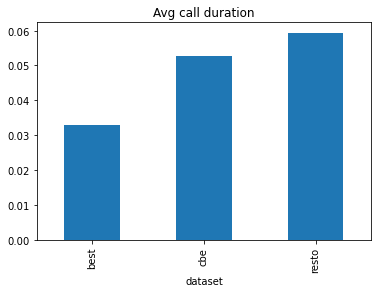

In [19]:
(timing.groupby("dataset").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:title={'center':'Avg call duration'}, xlabel='method'>

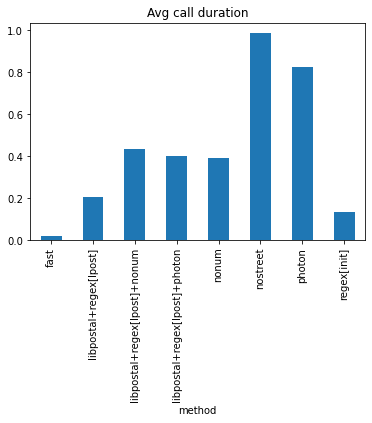

In [20]:
(timing.groupby("method").time.mean()).plot.bar(title="Avg call duration")

<AxesSubplot:xlabel='dataset'>

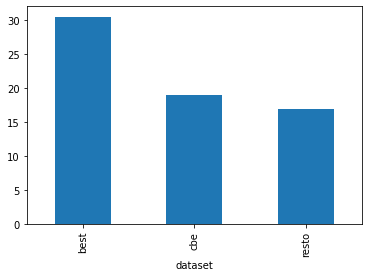

In [21]:
(1/timing.groupby("dataset").time.mean()).plot.bar("Iterations per seconds")

dataset
best     AxesSubplot(0.125,0.125;0.775x0.755)
cbe      AxesSubplot(0.125,0.125;0.775x0.755)
resto    AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

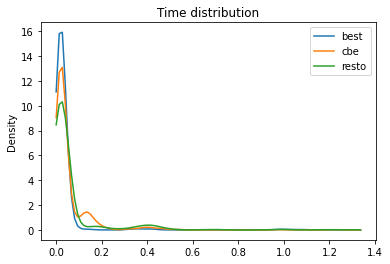

In [22]:
timing.groupby("dataset").time.plot.kde(legend=True, ind=np.linspace(0,timing.time.max(), 100 ), title="Time distribution" )

method
fast                             AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]           AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+nonum     AxesSubplot(0.125,0.125;0.775x0.755)
libpostal+regex[lpost]+photon    AxesSubplot(0.125,0.125;0.775x0.755)
nonum                            AxesSubplot(0.125,0.125;0.775x0.755)
nostreet                         AxesSubplot(0.125,0.125;0.775x0.755)
regex[init]                      AxesSubplot(0.125,0.125;0.775x0.755)
Name: time, dtype: object

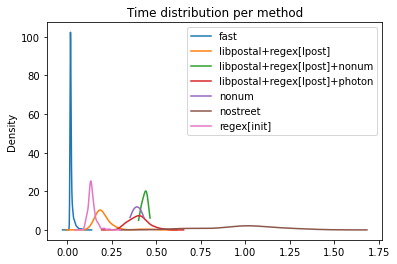

In [23]:
mthd_vc= timing.method.value_counts()
mthd_vc[mthd_vc==1]
timing[~timing.method.isin(mthd_vc[mthd_vc==1].index)][["method", "time"]].groupby("method").time.plot.kde(legend=True, title="Time distribution per method" )

<AxesSubplot:title={'center':'time'}, xlabel='[dataset]'>

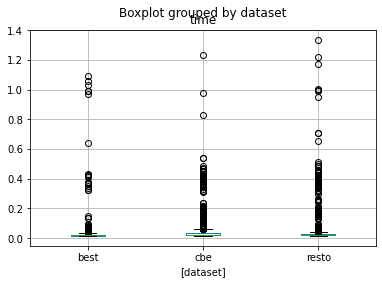

In [24]:
timing[["time", "dataset"]].boxplot(by="dataset")#.boxplot()

<AxesSubplot:title={'center':'Iterations per second'}>

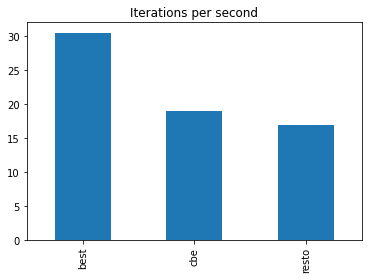

In [25]:
(timing.dataset.value_counts()/timing.groupby("dataset").time.sum()).plot.bar(title="Iterations per second")

In [26]:
addresses_seq_out = format_ws_res(addresses_seq)
addresses_seq_out

metadata                    \
           method addrKey placeRank   
0            fast       0        30   
1            fast       1        26   
2            fast       2        30   
3            fast       3        26   
4            fast       4        30   
...           ...     ...       ...   
2995  regex[init]    2995        30   
2996         fast    2996        26   
2997         fast    2997        26   
2998         fast    2998        26   
2999         fast    2999        30   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2995                              Rue du Wainage          62     5060   
2996                         Chaussée de Tournai         NaN     7520   
2997                              Rue Louis Caty         NaN     7331   
2998                          Drève des Bouleaux         NaN     7090   
2999                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2995      Sambreville  België / Belgique / Belgien   
2996   Ramegnies-Chin  België / Belgique / Belgien   
2997   Saint-Ghislain  België / Belgique / Belgien   
2998  Braine-le-Comte  België / Belgique / Belgien   
2999              Spa  België / Belgique / Belgien   

                                                                          \
                                            displayName lpostHouseNumber   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...              198   
1     Rue de la Halle, Namur, Wallonie, 5000, België...               11   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...               38   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...              200   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...                9   
...                                                 ...              ...   
2995  62, Rue du Wainage, Keumiée, Sambreville, Namu...               62   
2996  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...                4   
2997  Rue Louis Caty, Quartier de la Charbonnière, B...               32   
2998  Drève des Bouleaux, Coraimont, Braine-le-Comte...                5   
2999  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...                1   

                                                                         
     lpostUnit                 lat                 lon            other  
0                       50.5556305   4.907401297756147              NaN  
1                       50.4627801           4.8655064              NaN  
2               50.868676699999995   4.321060219298245              NaN  
3                       50.4161219           6.1119552              NaN  
4                       51.0399911           4.8089699              NaN  
...        ...                 ...                 ...              ...  
2995       NaN           50.462361  4.5964580703527815  Namur - Keumiée  
2996                    50.6394448           3.3490581              NaN  
2997                    50.4797372           3.8389755              NaN  
2998                    50.6063976           

In [27]:
# addresses_seq_out[addresses_seq_out[("output", "lat")].isnull()]

In [28]:
# rejected_seq_out = format_ws_res(rejected)
# rejected_seq_out

rejected = addresses_seq.json.apply(lambda js: pd.Series(js["rejected"]) if js is not None and "rejected" in js and len(js["rejected"])>0 else pd.Series(dtype=object))
rejected = rejected.unstack().dropna()
rejected = split_columns(rejected.apply(pd.Series))
rejected

metadata                                                 \
                        method addrKey placeRank rejectReason distanceToMatch   
0  4                      fast       4        30         tail           0.021   
   9                      fast       9        26         tail           0.055   
   13                     fast      13        26         tail           0.108   
   15                     fast      15        30         tail           0.011   
   22                     fast      22        26         tail           0.053   
...                        ...     ...       ...          ...             ...   
46 443  libpostal+regex[lpost]     443      30.0         tail            0.61   
47 94   libpostal+regex[lpost]      94      30.0         tail          15.553   
   443  libpostal+regex[lpost]     443      30.0         tail             0.4   
48 94   libpostal+regex[lpost]      94      30.0         tail          11.252   
   443  libpostal+regex[lpost]     443      30.0         tail           0.585   

                                      output                       \
                                  streetName houseNumber postCode   
0  4                      Kleine Waterstraat           9     2235   
   9            Place Jourdan - Jourdanplein         NaN     1040   
   13                     Rue des Charmilles         NaN     4960   
   15                      Chaussée de Liège        1178     5101   
   22                            Place Verte         NaN     4800   
...                                      ...         ...      ...   
46 443              Rue du Midi - Zuidstraat           8     1000   
47 94                               Wipplein         7;8     2850   
   443  Rue des Hirondelles - Zwaluwenstraat           8     1000   
48 94                       Lijsterbolstraat        7;7A     2550   
   443    Boulevard d'Anvers - Antwerpselaan           8     1000   

                                                          \
                   postName                  countryName   
0  4               Hulshout  België / Belgique / Belgien   
   9              Etterbeek  België / Belgique / Belgien   
   13               Malmedy  België / Belgique / Belgien   
   15       Lives-sur-Meuse  België / Belgique / Belgien   
   22              Verviers  België / Belgique / Belgien   
...                     ...                          ...   
46 443  Bruxelles - Brussel  België / Belgique / Belgien   
47 94                  Boom  België / Belgique / Belgien   
   443  Bruxelles - Brussel  België / Belgique / Belgien   
48 94               Kontich  België / Belgique / Belgien   
   443  Bruxelles - Brussel  België / Belgique / Belgien   

                                                                               \
                                              displayName                 lat   
0  4    9, Kleine Waterstraat, Houtvenne, Hulshout, Tu...         51.03990125   
   9    Place Jourdan - Jourdanplein, Etterbeek, Bruss...          50.8375788   
   13   Rue des Charmilles, Xhoffraix, Malmedy, Vervie...          50.4610681   
   15   New Hotel de Lives-sur-meuse, 1178, Chaussée d...          50.4780918   
   22   Place Verte, Ensival, Verviers, Liège, Walloni...           50.592586   
...                                                   ...                 ...   
46 443  8, Rue du Midi - Zuidstraat, Quartier du Centr...           50.847404   
47 94   7;8, Wipplein, Boom, Antwerpen, Vlaanderen, 28...         51.08806985   
   443  8, Rue des Hirondelles - Zwaluwenstraat, Quart...          50.8522407   
48 94   7;7A, Lijsterbolstraat, Kontich, Antwerpen, Vl...         51.12933245   
   443  8, Boulevard d'Anvers - Antwerpselaan, Bruxell...  50.856144549999996   

                                                                               
                       lon                                              other  
0  4     4.808706157426299                                                N

In [29]:
addresses_seq_out[addresses_seq_out[("metadata", "addrKey")] == "443"]

metadata                    \
                     method addrKey placeRank   
443  libpostal+regex[lpost]     443        30   

                               output                       \
                           streetName houseNumber postCode   
443  Rue du Persil - Peterseliestraat           8     1000   

                                                       \
                postName                  countryName   
443  Bruxelles - Brussel  België / Belgique / Belgien   

                                                                         \
                                           displayName lpostHouseNumber   
443  Les Amis Philanthropes nº 3, 8, Rue du Persil ...             8-10   

                                     \
    lpostUnit        lat        lon   
443       NaN  50.851256  4.3572509   

                                                        
                                                 other  
443  Pentagone - Vijfhoek - Les Amis Philanthropes ...

In [30]:
# addresses_seq_out[addresses_seq_out[("metadata", "retryOn26")] =="True"]

In [32]:
addresses.loc[443]


addrKey                     443
streetName     Predikherentraat
houseNumber                8-10
postName       BRUXELLES CENTRE
postCode                   1000
countryName            Belgique
dataset                   resto
Name: 443, dtype: object

In [33]:
addresses_seq_out[("metadata", "method")].value_counts(dropna=False)

fast                             2725
regex[init]                       113
libpostal+regex[lpost]+photon      90
libpostal+regex[lpost]             46
nostreet                           19
libpostal+regex[lpost]+nonum        3
nonum                               2
NaN                                 1
photon                              1
Name: (metadata, method), dtype: int64

In [34]:
# addresses_seq_out[addresses_seq_out[("work", 0)].isnull()]
addresses_seq_out[addresses_seq_out[("metadata", "method")] != "fast"]

metadata                                 output  \
                             method addrKey placeRank           streetName   
10    libpostal+regex[lpost]+photon      10        26    Avenue Albert Ier   
32                         nostreet      32        20     Klein-Willebroek   
33    libpostal+regex[lpost]+photon      33        30    Rue du Roi Albert   
36           libpostal+regex[lpost]      36        30     Rue Hors-Château   
37    libpostal+regex[lpost]+photon      37        26    Allée des Érables   
...                             ...     ...       ...                  ...   
2974                    regex[init]    2974        30           Hoogstraat   
2977         libpostal+regex[lpost]    2977        30  Twaalfmaandenstraat   
2980                    regex[init]    2980        26   Rue de Quevaucamps   
2987         libpostal+regex[lpost]    2987        30         Rue des Prés   
2995                    regex[init]    2995        30       Rue du Wainage   

                                                                           \
     houseNumber postCode           postName                  countryName   
10           NaN     4607             Feneur  België / Belgique / Belgien   
32           NaN     2850         Willebroek  België / Belgique / Belgien   
33             4     4102            Seraing  België / Belgique / Belgien   
36       25 - 27     4000              Liège  België / Belgique / Belgien   
37           NaN     4000              Liège  België / Belgique / Belgien   
...          ...      ...                ...                          ...   
2974          13     9450           Haaltert  België / Belgique / Belgien   
2977          17     2000          Antwerpen  België / Belgique / Belgien   
2980         NaN     7971           Basècles  België / Belgique / Belgien   
2987           9     6900  Marche-en-Famenne  België / Belgique / Belgien   
2995          62     5060        Sambreville  België / Belgique / Belgien   

                                                                          \
                                            displayName lpostHouseNumber   
10    Avenue Albert Ier, Feneur, Dalhem, Liège, Wall...               14   
32    Klein-Willebroek, Willebroek, Mechelen, Antwer...               10   
33    4, Rue du Roi Albert, Ougrée, Seraing, Liège, ...                4   
36    Église Notre-Dame-de-l'Immaculée-Conception, 2...          27c;27c   
37    Allée des Érables, Liège, Wallonie, 4000, Belg...              NaN   
...                                                 ...              ...   
2974  13, Hoogstraat, Haaltert, Aalst, Oost-Vlaander...               13   
2977  17, Twaalfmaandenstraat, Wilde Zee, Antwerpen,...               17   
2980  Rue de Quevaucamps, Basècles, Belœil, Ath, Hai...               19   
2987  9, Rue des Prés, Waha, Marche-en-Famenne, Luxe...                9   
2995  62, Rue du Wainage, Keumiée, Sambreville, Namu...               62   

                                                        \
     lpostUnit                 lat                 lon   
10         NaN           50.709418           5.7212279   
32         NaN          51.0809815           4.3664578   
33         NaN          50.5999714   5.534529605620154   
36         NaN  50.647537549999996   5.578972173776486   
37         NaN          50.5772727           5.5937698   
...        ...                 ...                 ...   
2974       NaN          50.9008776   4.005555559299696   
2977       NaN         51.21859445   4.406012982607047   
2980       NaN          50.5227341           3.6611157   
2987       NaN  50.202871349999995   5.316060794052932   
2995       NaN           50.462361  4.5964580703527815   

                                                         
                                                  other  
10                                                Liège  
32                                 Mechelen - Antwerpen  
33                                

In [35]:
call_ws(addresses_seq.loc[700], check_result=False, with_rejected=False)

{'match': [{'metadata': {'method': 'fast',
    'addrKey': '700',
    'placeRank': '30',
    'placeId': '1017524',
    'transformedAddress': 'Schoenmarkt, 5, 2800 MALINES, Belgique',
    'osmOrder': 0,
    'matchOnCleansedHouseNumber': True,
    'cleansedHouseNumber': '5'},
   'output': {'streetName': 'Schoenmarkt',
    'houseNumber': '5;6',
    'postCode': '2800',
    'postName': 'Mechelen',
    'countryName': 'België / Belgique / Belgien',
    'displayName': 'Bar Klak, 5;6, Schoenmarkt, Mechelen, Antwerpen, Vlaanderen, 2800, België / Belgique / Belgien',
    'lpostHouseNumber': '5/6',
    'lpostUnit': '',
    'lat': 51.027731599999996,
    'lon': 4.4794115140428055},
   'check': {}}],
 'time': 0.034814}

In [36]:
# call_ws(addresses_seq.loc[4], check_result=False, with_rejected=True)

In [37]:
# addresses_seq_out[addresses_seq.json.apply(lambda js: "osmOrder" in js["match"][0]['work'] if js else None).fillna(False)]

In [38]:
addresses_seq

,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset,json
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto,"{'match': [{'metadata': {'method': 'fast', 'ad..."
...,...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe,{'match': [{'metadata': {'method': 'regex[init...
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe,"{'match': [{'metadata': {'method': 'fast', 'ad..."


### Using Dask

In [39]:
addresses_dask = addresses.copy()

In [40]:
addresses_dask

,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [41]:
t = datetime.now()
dd_addresses = dd.from_pandas(addresses_dask.fillna(""), npartitions=8)

dask_task = dd_addresses.apply(call_ws, check_result=False, meta=('x', 'str'), axis=1)

with ProgressBar(): 
    addresses_dask["json"] = dask_task.compute()
    

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["dask"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO dataset:
# Normal mode: 24.52 seconds, 40.79 it/s
# Fastmode:    15.81 seconds, 63.27 it/s


# Resto dataset:
# Normal mode: 27.86 seconds, 35.89 it/s
# Fast mode:   18.44 seconds, 54.23 it/s

# Best dataset: 
# Normal mode: 16.11 seconds, 62.07 it/s
# Fast mode:    9.76 seconds, 102.42 it/s

[                                        ] | 0% Completed |  5.3sNo result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}

[########################################] | 100% Completed | 30.6s
30.59 seconds, 98.06 it/s


In [42]:
# 1000, 1 worker: 4m18
# 4 workers, npart=4 : 1m20
# 8 workers, npart=4 : 1m20
# 8 workers, npart=8 : 44s

# with checker=False:
# 8 workers, npart=8 : 24s


In [43]:
# expand_json(addresses_dask)

addresses_dask_out = format_ws_res(addresses_dask)
addresses_dask_out

metadata                             \
           method addrKey placeRank  placeId   
0            fast       0        30  2580480   
1            fast       1        26   392307   
2            fast       2        30  1094419   
3            fast       3        26   342040   
4            fast       4        30   171744   
...           ...     ...       ...      ...   
2995  regex[init]    2995        30  2657266   
2996         fast    2996        26  1983533   
2997         fast    2997        26   432987   
2998         fast    2998        26   379561   
2999         fast    2999        30  1868481   

                                                                  \
                                     transformedAddress osmOrder   
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique        0   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique        0   
2     Avenue Jacques Sermon, 38, 1083 GANSHOREN, Bel...        0   
3             rue du Centre, 200, 4950 WAIMES, Belgique        0   
4        Kleine Waterstraat, 9, 2235 HULSHOUT, Belgique        0   
...                                                 ...      ...   
2995     Rue du Wainage, 62, 5060 Sambreville, Belgique        0   
2996  Chaussée de Tournai(R-C), 4, 7520 Tournai, Bel...        0   
2997  Rue Louis Caty(B), 32, 7331 Saint-Ghislain, Be...        0   
2998  Drève des Bouleaux, 5, 7090 Braine-le-Comte, B...        0   
2999                  Rue Rogier, 1, 4900 Spa, Belgique        0   

                                                     \
     matchOnCleansedHouseNumber cleansedHouseNumber   
0                           NaN                 NaN   
1                           NaN                 NaN   
2                           NaN                 NaN   
3                           NaN                 NaN   
4                           NaN                 NaN   
...                         ...                 ...   
2995                        NaN                 NaN   
2996                        NaN                 NaN   
2997                        NaN                 NaN   
2998                        NaN                 NaN   
2999                        NaN                 NaN   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2995                              Rue du Wainage          62     5060   
2996                         Chaussée de Tournai         NaN     7520   
2997                              Rue Louis Caty         NaN     7331   
2998                          Drève des Bouleaux         NaN     7090   
2999                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2995      Sambreville  België / Belgique / Belgien   
2996   Ramegnies-Chin  België / Belgique / Belgien   
2997   Saint-Ghislain  België / Belgique / Belgien   
2998  Braine-le-Comte  België / Belgique / Belgien   
2999              Spa  België / Belgique / Belgien   

                                                                          \
                                            displayNam

In [44]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].merge(
    addresses_dask_out[fields], how="outer", indicator=True)
if mg.shape[0] == addresses.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_52253/615264633.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].merge(


In [45]:
mg

metadata                        output           \
      addrKey       method         postName postCode   
0           0         fast            Leuze     5310   
1           1         fast            Namur     5000   
2           2         fast        Ganshoren     1083   
3           3         fast           Waimes     4950   
4           4         fast         Hulshout     2235   
...       ...          ...              ...      ...   
2995     2995  regex[init]      Sambreville     5060   
2996     2996         fast   Ramegnies-Chin     7520   
2997     2997         fast   Saint-Ghislain     7331   
2998     2998         fast  Braine-le-Comte     7090   
2999     2999         fast              Spa     4900   

                                                             _merge  
                                      streetName houseNumber         
0                              Chaussée de Namur         198   both  
1                                Rue de la Halle         NaN   both  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38   both  
3                                  Rue du Centre         NaN   both  
4                             Kleine Waterstraat           9   both  
...                                          ...         ...    ...  
2995                              Rue du Wainage          62   both  
2996                         Chaussée de Tournai         NaN   both  
2997                              Rue Louis Caty         NaN   both  
2998                          Drève des Bouleaux         NaN   both  
2999                                  Rue Rogier           1   both  

[3000 rows x 7 columns]

## Batch calls (batch WS)

### Single block

In [46]:
# addresses=addresses[addresses.addrKey.isin(["1075", "1331", "2616"])]
# addresses=addresses[addresses.addrKey.isin(["2206", "2556", "2569", "2715"])]
# addresses=addresses.iloc[0:10]
addresses


,addrKey,streetName,houseNumber,postName,postCode,countryName,dataset
0,0,Chaussée de Namur,198,LEUZE,5310,Belgique,resto
1,1,Rue de la Halle,11,NAMUR,5000,Belgique,resto
2,2,Avenue Jacques Sermon,38,GANSHOREN,1083,Belgique,resto
3,3,rue du Centre,200,WAIMES,4950,Belgique,resto
4,4,Kleine Waterstraat,9,HULSHOUT,2235,Belgique,resto
...,...,...,...,...,...,...,...
2995,2995,Rue du Wainage(VEL),62,Sambreville,5060,Belgique,cbe
2996,2996,Chaussée de Tournai(R-C),4,Tournai,7520,Belgique,cbe
2997,2997,Rue Louis Caty(B),32,Saint-Ghislain,7331,Belgique,cbe
2998,2998,Drève des Bouleaux,5,Braine-le-Comte,7090,Belgique,cbe


In [47]:
t = datetime.now()

addresses_batch, rejected = call_ws_batch(addresses[[addr_key_field, 
                                           street_field, housenbr_field, postcode_field, city_field, country_field]], 
                                mode="short", 
                                check_result=False, 
                                structured_osm=False,
                                with_rejected=False)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses.shape[0]/tot_time
iter_per_sec_stats["batch_single_bloc"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")


# KBO dataset: 33.94 seconds, 29.46 it/s
# Best:        24.99 seconds, 40.01 it/s
# Resto:       38.33 seconds, 26.09 it/s

addresses_batch

79.66 seconds, 37.66 it/s


metadata                             \
           method addrKey placeRank  placeId   
0            orig       0        30  2580480   
1            orig       1        26   392307   
2            orig       2        30  1094419   
3            orig       3        26   342040   
4            orig       4        30   171744   
...           ...     ...       ...      ...   
2994  regex[init]    2995        30  2657266   
2995         orig    2996        26  1983533   
2996         orig    2997        26   432987   
2997         orig    2998        26   379561   
2998         orig    2999        30  1868481   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2994                              Rue du Wainage          62     5060   
2995                         Chaussée de Tournai         NaN     7520   
2996                              Rue Louis Caty         NaN     7331   
2997                          Drève des Bouleaux         NaN     7090   
2998                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2994      Sambreville  België / Belgique / Belgien   
2995   Ramegnies-Chin  België / Belgique / Belgien   
2996   Saint-Ghislain  België / Belgique / Belgien   
2997  Braine-le-Comte  België / Belgique / Belgien   
2998              Spa  België / Belgique / Belgien   

                                                         \
                                            displayName   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...   
1     Rue de la Halle, Namur, Wallonie, 5000, België...   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...   
...                                                 ...   
2994  62, Rue du Wainage, Keumiée, Sambreville, Namu...   
2995  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...   
2996  Rue Louis Caty, Quartier de la Charbonnière, B...   
2997  Drève des Bouleaux, Coraimont, Braine-le-Comte...   
2998  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...   

                                                                          \
                                                  other lpostHouseNumber   
0                                       Namur - Éghezée              198   
1                                                   NaN               11   
2                Brussel-Hoofdstad - Bruxelles-Capitale               38   
3                                      Verviers - Liège              200   
4     Turnhout - Tennisclub Lybo - Antwerpen - Houtv...                9   
...                                                 ...              ...   
2994                                    Namur - Keumiée               62   
2995     Hurette - Hainaut - Tournai - Tournai-Mouscron                4   
2996  Baudour - Hainaut - Quartier de la Charbonnièr...               32   
2997                     Hainaut - Soignies - Coraimont                5   
2998                                   Verviers - L

In [48]:
addresses_batch[("check", "SIMStreetWhich")].value_counts() if ("check", "SIMStreetWhich") in addresses_batch else None

In [49]:
addresses_batch[ addresses_batch[("check", "SIMStreetWhich")] != "street_name"] if ("check", "SIMStreetWhich") in addresses_batch else None

In [50]:
addresses_batch[("metadata", "method")].value_counts()

orig                             2725
regex[init]                       113
libpostal+regex[lpost]+photon      90
libpostal+regex[lpost]             46
nostreet                           19
libpostal+regex[lpost]+nonum        3
nonum                               2
photon                              1
Name: (metadata, method), dtype: int64

In [51]:
rejected

""


In [52]:
fields

[('metadata', 'addrKey'),
 ('metadata', 'method'),
 ('output', 'postName'),
 ('output', 'postCode'),
 ('output', 'streetName'),
 ('output', 'houseNumber')]

In [53]:
# addresses_seq_out[fields].dropna(subset=[("input", addr_key_field)]).replace("fast", "orig").merge(
#     addresses_batch[fields], how="outer", indicator=True)
# addresses_batch[fields]

In [54]:
# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch[fields], how="outer", indicator=True)

# mg = addresses_seq[[  "city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch[["city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna(""), how="outer", indicator=True)
if mg[mg._merge == "both"].shape[0] == addresses_batch.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_52253/306358533.py:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


In [55]:
mg

metadata                        output           \
      addrKey       method         postName postCode   
0           0         orig            Leuze     5310   
1           1         orig            Namur     5000   
2           2         orig        Ganshoren     1083   
3           3         orig           Waimes     4950   
4           4         orig         Hulshout     2235   
...       ...          ...              ...      ...   
2994     2995  regex[init]      Sambreville     5060   
2995     2996         orig   Ramegnies-Chin     7520   
2996     2997         orig   Saint-Ghislain     7331   
2997     2998         orig  Braine-le-Comte     7090   
2998     2999         orig              Spa     4900   

                                                             _merge  
                                      streetName houseNumber         
0                              Chaussée de Namur         198   both  
1                                Rue de la Halle         NaN   both  
2     Avenue Jacques Sermon - Jacques Sermonlaan          38   both  
3                                  Rue du Centre         NaN   both  
4                             Kleine Waterstraat           9   both  
...                                          ...         ...    ...  
2994                              Rue du Wainage          62   both  
2995                         Chaussée de Tournai         NaN   both  
2996                              Rue Louis Caty         NaN   both  
2997                          Drève des Bouleaux         NaN   both  
2998                                  Rue Rogier           1   both  

[2999 rows x 7 columns]

In [56]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="coordinates", 
                           check_result=True, 
                           with_rejected=True) 
match

metadata                                output                    
        method addrKey placeRank                 lat                 lon
0         orig       0        30          50.5556305   4.907401297756147
1         orig       1        26          50.4627801           4.8655064
2         orig    1000        26          50.9566699           3.6415525
3         orig    1001        30         50.91119645  4.7150743897059115
4         orig    1002        30          50.8265812   4.302949641747071
...        ...     ...       ...                 ...                 ...
2994  nostreet     669        21   51.21132184441221    4.32753532032106
2995  nostreet     682        14          50.4265348           6.0276059
2996  nostreet     758        21    50.1556859003716   5.203150031937894
2997  nostreet      93        19          50.3416114            4.838456
2998  nostreet      94        21  51.274763050000004   4.357808558108607

[2999 rows x 5 columns]

In [57]:
# rej[rej[("metadata", "rejectReason")]!="tail"]

In [58]:
# rej[rej.duplicated(keep=False)]

In [59]:
# Geocode + address
match, rej = call_ws_batch(addresses[[addr_key_field, street_field, housenbr_field, postcode_field, city_field, country_field]], 
                           mode="short", 
                           check_result=False) 
match


metadata                             \
           method addrKey placeRank  placeId   
0            orig       0        30  2580480   
1            orig       1        26   392307   
2            orig       2        30  1094419   
3            orig       3        26   342040   
4            orig       4        30   171744   
...           ...     ...       ...      ...   
2994  regex[init]    2995        30  2657266   
2995         orig    2996        26  1983533   
2996         orig    2997        26   432987   
2997         orig    2998        26   379561   
2998         orig    2999        30  1868481   

                                          output                       \
                                      streetName houseNumber postCode   
0                              Chaussée de Namur         198     5310   
1                                Rue de la Halle         NaN     5000   
2     Avenue Jacques Sermon - Jacques Sermonlaan          38     1083   
3                                  Rue du Centre         NaN     4950   
4                             Kleine Waterstraat           9     2235   
...                                          ...         ...      ...   
2994                              Rue du Wainage          62     5060   
2995                         Chaussée de Tournai         NaN     7520   
2996                              Rue Louis Caty         NaN     7331   
2997                          Drève des Bouleaux         NaN     7090   
2998                                  Rue Rogier           1     4900   

                                                    \
             postName                  countryName   
0               Leuze  België / Belgique / Belgien   
1               Namur  België / Belgique / Belgien   
2           Ganshoren  België / Belgique / Belgien   
3              Waimes  België / Belgique / Belgien   
4            Hulshout  België / Belgique / Belgien   
...               ...                          ...   
2994      Sambreville  België / Belgique / Belgien   
2995   Ramegnies-Chin  België / Belgique / Belgien   
2996   Saint-Ghislain  België / Belgique / Belgien   
2997  Braine-le-Comte  België / Belgique / Belgien   
2998              Spa  België / Belgique / Belgien   

                                                         \
                                            displayName   
0     198, Chaussée de Namur, Leuze, Éghezée, Namur,...   
1     Rue de la Halle, Namur, Wallonie, 5000, België...   
2     38, Avenue Jacques Sermon - Jacques Sermonlaan...   
3     Rue du Centre, Waimes, Verviers, Liège, Wallon...   
4     Tennisclub Lybo, 9, Kleine Waterstraat, Houtve...   
...                                                 ...   
2994  62, Rue du Wainage, Keumiée, Sambreville, Namu...   
2995  Chaussée de Tournai, Hurette, Ramegnies-Chin, ...   
2996  Rue Louis Caty, Quartier de la Charbonnière, B...   
2997  Drève des Bouleaux, Coraimont, Braine-le-Comte...   
2998  1, Rue Rogier, Spa, Verviers, Liège, Wallonie,...   

                                                                          \
                                                  other lpostHouseNumber   
0                                       Namur - Éghezée              198   
1                                                   NaN               11   
2                Brussel-Hoofdstad - Bruxelles-Capitale               38   
3                                      Verviers - Liège              200   
4     Turnhout - Tennisclub Lybo - Antwerpen - Houtv...                9   
...                                                 ...              ...   
2994                                    Namur - Keumiée               62   
2995     Hurette - Hainaut - Tournai - Tournai-Mouscron                4   
2996  Baudour - Hainaut - Quartier de la Charbonnièr...               32   
2997                     Hainaut - Soignies - Coraimont                5   
2998                                   Verviers - L

In [60]:
rej

""


In [61]:
# Geocode + address, with rejected addresses
match, rej = call_ws_batch(addresses, mode="long", with_rejected=True)
match

metadata                             \
        method addrKey placeRank  placeId   
0         orig       0        30  2580480   
1         orig       1        26   392307   
2         orig    1000        26   945686   
3         orig    1001        30  1107156   
4         orig    1002        30  1030137   
...        ...     ...       ...      ...   
2994  nostreet     669        21  4004242   
2995  nostreet     682        14  3934860   
2996  nostreet     758        21  4004734   
2997  nostreet      93        19   102030   
2998  nostreet      94        21  3994333   

                                                                  \
                                     transformedAddress osmOrder   
0          Chaussée de Namur, 198, 5310 LEUZE, Belgique        0   
1             Rue de la Halle, 11, 5000 NAMUR, Belgique        0   
2                Steenweg, 269, 9810 Nazareth, Belgique        0   
3              Centrumstraat, 5, 3012 Louvain, Belgique        0   
4     Rue Félix De Cuyper, 39, 1070 Anderlecht, Belg...        0   
...                                                 ...      ...   
2994                         2070 ZWIJNDRECHT, Belgique        0   
2995                             4950 MALMEDY, Belgique        0   
2996                           5580 ROCHEFORT, Belgique        0   
2997                   5537 ANNEVOIE-ROUILLON, Belgique        0   
2998                              2030 ANVERS, Belgique        0   

                                           output                       \
                                       streetName houseNumber postCode   
0                               Chaussée de Namur         198     5310   
1                                 Rue de la Halle         NaN     5000   
2                                        Steenweg         NaN     9810   
3                                   Centrumstraat           5     3012   
4     Rue Félix De Cuyper - Félix De Cuyperstraat          39     1070   
...                                           ...         ...      ...   
2994                                          NaN         NaN     2070   
2995                                          NaN         NaN     4960   
2996                                          NaN         NaN     5580   
2997                                          NaN         NaN     5537   
2998                                          NaN         NaN     2030   

                         ...  \
               postName  ...   
0                 Leuze  ...   
1                 Namur  ...   
2                   Eke  ...   
3               Wilsele  ...   
4            Anderlecht  ...   
...                 ...  ...   
2994        Zwijndrecht  ...   
2995            Malmedy  ...   
2996          Rochefort  ...   
2997  Annevoie-Rouillon  ...   
2998                NaN  ...   

                                                                          \
                                                  other lpostHouseNumber   
0                                       Namur - Éghezée              198   
1                                                   NaN               11   
2                                Gent - Oost-Vlaanderen              269   
3                               Leuven - Vlaams-Brabant                5   
4     Veeweyde - Veeweide - Aa - Brussel-Hoofdstad -...               39   
...                                                 ...              ...   
2994                                          Antwerpen               93   
2995                                   Verviers - Liège               24   
2996                                     Namur - Dinant                5   
2997                                     Namur - Dinant               35   
2998                                          Antwerpen                7   

                                                                check  \
                     lat                 lon lpostUnit simStreetWhich   
0             50.555

In [62]:
rej

metadata                                                          \
        method addrKey placeRank  placeId rejectReason distanceToMatch   
0         orig      93        30  2559050     mismatch           0.815   
1         orig     229        26   464301     mismatch           2.299   
2         orig     292        30  1202464     mismatch           1.557   
3         orig     785        30  1795841     mismatch           5.407   
4         orig     797        30  1277066     mismatch           2.646   
...        ...     ...       ...      ...          ...             ...   
1171  nostreet     198        21  4004235         tail           0.114   
1172  nostreet     337        21  4004235         tail           0.114   
1173  nostreet     473        21  4004236         tail           0.326   
1174  nostreet     602        21  4004236         tail           0.326   
1175  nostreet      94        21  4004238         tail           3.835   

                                                                  \
                                     transformedAddress osmOrder   
0     route des Jardins, 35, 5537 ANNEVOIE-ROUILLON,...        0   
1                Jardon, 46-48, 4800 VERVIERS, Belgique        3   
2     Place Wiener, 4, 1170 WATERMAEL-BOITSFORT, Bel...        2   
3                      Dorp, 29, 2980 ZOERSEL, Belgique        2   
4            Rue du Collège, 33, 4600 BERNEAU, Belgique        0   
...                                                 ...      ...   
1171                       2000 ANVERS-CENTRE, Belgique        1   
1172                       2000 ANVERS-CENTRE, Belgique        1   
1173                              2018 ANVERS, Belgique        1   
1174                              2018 ANVERS, Belgique        1   
1175                              2030 ANVERS, Belgique        1   

                                          output              ...  \
                                      streetName houseNumber  ...   
0                     Rue des Jardins d'Annevoie          35  ...   
1                           Avenue Julien Jardon         NaN  ...   
2     Avenue Léopold Wiener - Léopold Wienerlaan           4  ...   
3                                     Halle-Dorp          29  ...   
4                                 Rue de Battice          33  ...   
...                                          ...         ...  ...   
1171                                         NaN         NaN  ...   
1172                                         NaN         NaN  ...   
1173                                         NaN         NaN  ...   
1174                                         NaN         NaN  ...   
1175                                         NaN         NaN  ...   

                                   \
                      countryName   
0     België / Belgique / Belgien   
1     België / Belgique / Belgien   
2     België / Belgique / Belgien   
3     België / Belgique / Belgien   
4     België / Belgique / Belgien   
...                           ...   
1171  België / Belgique / Belgien   
1172  België / Belgique / Belgien   
1173  België / Belgique / Belgien   
1174  België / Belgique / Belgien   
1175  België / Belgique / Belgien   

                                                         \
                                            displayName   
0     35, Rue des Jardins d'Annevoie, Rouillon, Anhé...   
1     Avenue Julien Jardon, Mangombroux, Stembert, V...   
2     4, Avenue Léopold Wiener - Léopold Wienerlaan,...   
3     29, Halle-Dorp, Halle, Zoersel, Antwerpen, Vla...   
4     33, Rue de Battice, Berneau, Dalhem, Liège, Wa...   
...                                                 ...   
1171  Antwerpen, Vlaanderen, 2000, België / Belgique...   
1172  Antwerpen, Vlaanderen, 2000, België / Belgique...   
1173  Antwerpen, Vlaanderen, 2018, België / Belgique...   
1174  Antwerpen, Vlaanderen, 2018, België / Belgique...   
1175  Antwerpen, Vlaanderen, 2030, België / Belgique...   

          

### Batch blocs

In [63]:
# addresses = addresses.sample(10000, replace=True)
# addresses = addresses.reset_index(drop=True)
# addresses["addr_key"]= addresses.index.astype(str)

In [64]:
t = datetime.now()

nb_threads=8

chunks = np.array_split(addresses, nb_threads) # addresses.shape[0]//100)

print(f"{len(chunks)} chunks on {nb_threads} threads")

import multiprocess as mp

p = mp.Pool(nb_threads)

def f(chunk):
    return call_ws_batch(chunk, mode="short", 
                        check_result=False, 
                        structured_osm=False)[0]

with p:
     res= list(tqdm(p.imap(f, chunks), total=len(chunks)))
    
addresses_batch2 = pd.concat(res).reset_index(drop=True)

tot_time = (datetime.now() - t).total_seconds()

ips=addresses_dask.shape[0]/tot_time
iter_per_sec_stats["batch_parallel_blocs"] = ips
print(f"{tot_time:.2f} seconds, {ips:.2f} it/s")

# KBO:    9.28 seconds, 107.72 it/s
# Best:   6.88 seconds, 145.43 it/s
# Resto: 11.79 seconds,  84.85 it/s

8 chunks on 8 threads


  0%|          | 0/8 [00:00<?, ?it/s]

21.43 seconds, 139.99 it/s


In [65]:
# addresses_batch2
# expand_batch_address(addresses_batch2)

In [66]:
fields = [("metadata", addr_key_field), ("metadata", "method"), ("output", city_field), ("output", postcode_field),("output", street_field), ("output", housenbr_field)]
mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(
    addresses_batch2[fields], how="outer", indicator=True)


# mg = addresses_seq[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna("").replace("fast", "orig").merge(
#      addresses_batch2[[addr_key_field, city_field, postcode_field,street_field, housenbr_field, f"addrOut{street_field}", f"addrOut{housenbr_field}", f"addrOut{postcode_field}", f"addrOut{city_field}"]].fillna(""), how="outer", indicator=True)

# mg = addresses_seq[[  "city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna("").replace("fast", "orig").merge(
#     addresses_batch2[["city", "postcode","street", "housenumber", "method", "addrOutStreet", "addrOutNumber", "addrOutPostcode", "addrOutCity", "addrKey"]].fillna(""), how="outer", indicator=True)
if mg[mg._merge == "both"].shape[0] == addresses_batch2.shape[0]:
    print("Same result in seq and dask run!")
else: 
    print("!!! Not the same result in seq and dask run!")
    

Same result in seq and dask run!


/tmp/ipykernel_52253/2339200656.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  mg = addresses_seq_out[fields].dropna(subset=[("metadata", addr_key_field)]).replace("fast", "orig").merge(


<AxesSubplot:title={'center':'Iterations per second'}>

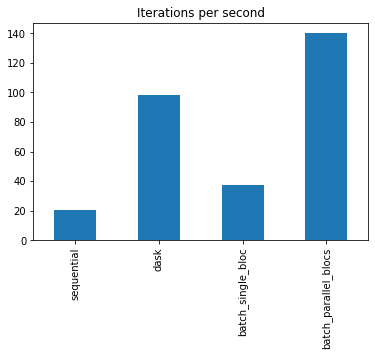

In [67]:
# pd.DataFrame(
pd.Series(iter_per_sec_stats).plot.bar(title='Iterations per second')

## Comparing options

In [68]:
addresses = addresses.sample(500)

In [ ]:
# Single call
results = {}
it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    results[(mode,  check_label, struct_label, extra_hn)] =  addresses.fillna("").apply(call_ws, 
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode,axis=1)

    it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(it_per_seconds))
print("Iterations per seconds (single calls):")
it_per_seconds = pd.DataFrame(it_per_seconds)
it_per_seconds

  0%|          | 0/24 [00:00<?, ?it/s]

coordinates check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.16121


coordinates check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.16121
1,coordinates,check,struct,noextrahn,5.45895


coordinates check unstruct extrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669


coordinates check unstruct noextrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758


coordinates nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294


coordinates nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521


coordinates nocheck unstruct extrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320


coordinates nocheck unstruct noextrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494


short check struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970


short check struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


short check unstruct extrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


short check unstruct noextrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


short nocheck struct extrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


short nocheck struct noextrahn


,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


short nocheck unstruct extrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


short nocheck unstruct noextrahn
No result!
{'addrKey': '784', 'streetName': 'route de Balmoral', 'houseNumber': '35', 'postName': 'SART-LEZ-SPA', 'postCode': '4845', 'countryName': 'Belgique', 'dataset': 'resto'}



,mode,check,struct,extra_hn,it_per_sec
0,coordinates,check,struct,extrahn,5.161210
1,coordinates,check,struct,noextrahn,5.458950
2,coordinates,check,unstruct,extrahn,5.164669
3,coordinates,check,unstruct,noextrahn,5.365758
4,coordinates,nocheck,struct,extrahn,23.276294
5,coordinates,nocheck,struct,noextrahn,25.409521
6,coordinates,nocheck,unstruct,extrahn,22.752320
7,coordinates,nocheck,unstruct,noextrahn,24.240494
8,short,check,struct,extrahn,5.308970
9,short,check,struct,noextrahn,5.371471


long check struct extrahn


In [ ]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second", ax=fl_ax[i])
plt.tight_layout()
#     plt.show()

In [ ]:
f, ax = plt.subplots(4,4, figsize=(12,8))
for i, fld1 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):
    for j, fld2 in enumerate(it_per_seconds.drop("it_per_sec", axis=1).columns):

        it_per_seconds.groupby([fld1, fld2]).it_per_sec.mean().unstack().plot.bar(ax=ax[i][j])

In [ ]:
# results

In [ ]:
# batch
batch_results = {}
batch_it_per_seconds = []# pd.DataFrame()#columns = [ "mode", "check", "struct", "extra_hn"])
            
for mode, check_label, struct_label, extra_hn in tqdm([(m, c, s, h) for m in ["coordinates", "short", "long"]
                                            for c in ["check", "nocheck"]
                                            for s in ["struct", "unstruct"]
                                            for h in ["extrahn", "noextrahn"]
                                            ]):            
    print(mode, check_label, struct_label, extra_hn)
    start=datetime.now()

    batch_results[(mode,  check_label, struct_label, extra_hn)] =  call_ws_batch(addresses,
                                                                              check_result=check_label == "check", 
                                                                              structured_osm=struct_label == "struct", 
                                                                              extra_house_number=extra_hn =="extrahn" ,
                                                                              with_rejected=False, 
                                                                              mode=mode)[0]

    batch_it_per_seconds.append({"mode": mode,
                           "check": check_label,
                           "struct": struct_label,
                           "extra_hn": extra_hn,
                           "it_per_sec": addresses.shape[0] / (datetime.now()-start).total_seconds()})
    display(pd.DataFrame(batch_it_per_seconds))
print("Iterations per seconds (batch calls):")
batch_it_per_seconds = pd.DataFrame(batch_it_per_seconds)
batch_it_per_seconds

In [ ]:
f, ax = plt.subplots(2,2, figsize=(12,8))
fl_ax=ax.flatten()
for i, fld in enumerate(batch_it_per_seconds.drop("it_per_sec", axis=1).columns):
    batch_it_per_seconds.groupby(fld).it_per_sec.mean().plot.bar(title="Avg. iteration per second (batch)", ax=fl_ax[i])
plt.tight_layout()

In [ ]:
print("Match rate (without nostreet)")
mr=[]
for k1 in ["struct", "unstruct"]:
    for k2 in ["check", "nocheck"]:
        keys = [k for k in  batch_results.keys() if k1 in k and k2 in k]
        mr.append({"struct": k1, "check": k2, "match_rate": min([batch_results[k][batch_results[k][("metadata", "method")]!="nostreet" ].shape[0]/addresses.shape[0] for k in keys])})

mr = pd.DataFrame(mr).set_index(["struct","check" ]).unstack()

mr.plot.bar() 
mr